In [38]:
import cellpose
import mitoanalysis
import numpy as np
import os
import matplotlib.pyplot as plt
from cellpose import models, io
from cellpose.io import imread

In [39]:
# list of files
# PUT PATH TO YOUR FILES HERE!
path = os.path.expanduser('~/mitosisanalyzer/data/')
files = mitoanalysis.get_files(path, fpattern=["*.nd2", "*.tiff", "*.tif"])

example_f = files[-1]
imgstack,meta = mitoanalysis.nd2_opener(example_f)
mid = len(imgstack)//2
imgslice = imgstack[mid] # np.median(imgstack, axis=0)

metadata['shape']={'t': 210, 'c': 2, 'y': 512, 'x': 512}
imagestack.shape=(210, 2, 512, 512)


In [40]:
io.logger_setup()

# model_type='cyto' or 'nuclei' or 'cyto2' or 'cyto3'
model = models.Cellpose(gpu=True, model_type='cyto3')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
channels = [[0,0]]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended)
# diameter can be a list or a single number for all images
pixel_diam = 50 / meta["pixel_res"]
masks, flows, styles, diams = model.eval([imgslice], diameter=pixel_diam, channels=channels, cellprob_threshold=1.0)
print (f"{imgslice.shape}")

2024-12-07 18:32:09,332 [INFO] WRITING LOG OUTPUT TO /home/khs3z/.cellpose/run.log
2024-12-07 18:32:09,333 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.10.13 
torch version:  	2.2.1
2024-12-07 18:32:09,343 [INFO] ** TORCH CUDA version installed and working. **
2024-12-07 18:32:09,344 [INFO] >>>> using GPU
2024-12-07 18:32:09,345 [INFO] >> cyto3 << model set to be used
2024-12-07 18:32:09,393 [INFO] >>>> loading model /home/khs3z/.cellpose/models/cyto3
2024-12-07 18:32:09,447 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-12-07 18:32:09,449 [INFO] channels set to [[0, 0]]
2024-12-07 18:32:09,450 [INFO] ~~~ FINDING MASKS ~~~
2024-12-07 18:32:09,785 [INFO] >>>> TOTAL TIME 0.34 sec
(2, 512, 512)


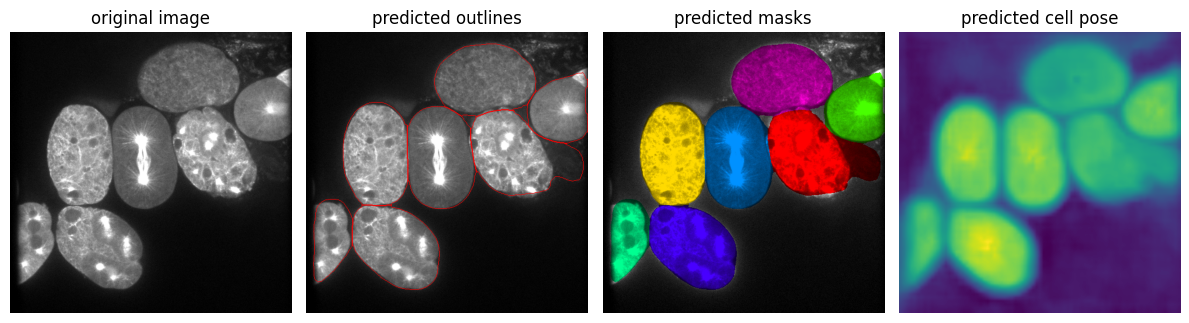

In [41]:
# DISPLAY RESULTS
from cellpose import plot

fig = plt.figure(figsize=(12,5))
ch = 0
plot.show_segmentation(fig, imgslice[0], masks[0], flows[0][2], channels=channels)
plt.tight_layout()
plt.show()

In [42]:
maskid = 4
embryo = np.where(np.array(len(imgstack)*[masks])==maskid, imgstack, 0*imgstack) 

In [43]:
embryo.shape

(210, 2, 512, 512)

In [44]:
pixel_diam = 4 / meta["pixel_res"]
print (pixel_diam)
x = 205
y = 230
wh = 5 * int(pixel_diam)

spindle = embryo[:, 0, :,:]
spindle_pole = spindle[:, y:y+wh, x:x+wh]#.astype(np.uint8)
spindle_pole_norm = cv2.normalize(spindle_pole, None, 0, 255.0, norm_type=cv2.NORM_MINMAX)
__, spindle_pole_th = cv2.threshold(spindle_pole_norm, 0.75 * 255, 255, cv2.THRESH_BINARY)
dna = embryo[:, 1, :,:]
dna_part = dna[:, y:y+wh, x:x+wh]
dna_part_norm = cv2.normalize(dna_part, None, 0, 255.0, norm_type=cv2.NORM_MINMAX)
print (f"max spindle intensity={spindle_pole_th.max()}")
spindle_pole_norm.shape

14.999999999999982
max spindle intensity=255.0


(210, 70, 70)

In [45]:

imgslice = np.array([spindle_pole[mid-10], dna_part[mid-10]])
imgslice = np.array([spindle_pole[mid-10]])
spindle_masks, flows, styles, diams = model.eval([imgslice], diameter=pixel_diam, channels=channels, cellprob_threshold=1.0)
print (f"{imgslice.shape}")

2024-12-07 18:32:10,579 [INFO] channels set to [[0, 0]]
2024-12-07 18:32:10,580 [INFO] ~~~ FINDING MASKS ~~~
2024-12-07 18:32:10,620 [INFO] >>>> TOTAL TIME 0.04 sec
(1, 70, 70)


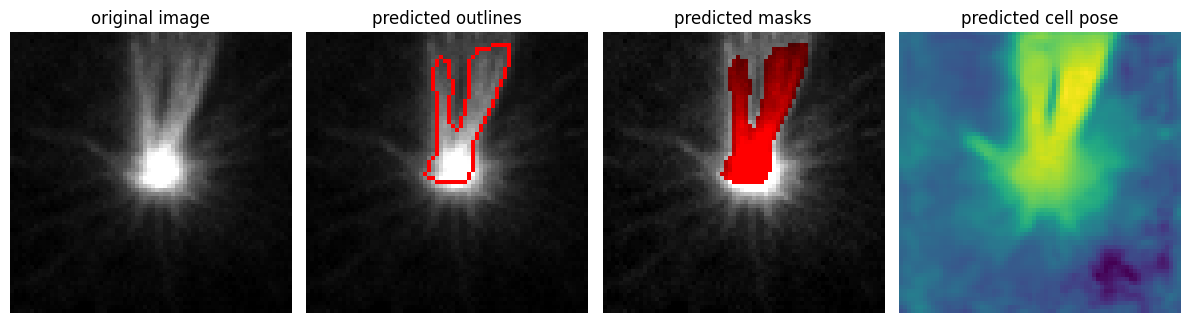

In [46]:
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, imgslice[0], spindle_masks[0], flows[0][2], channels=channels)
plt.tight_layout()
plt.show()

In [75]:
def crop_image(img, crop_origin=None, crop_width=None, crop_height=None, x_index=1, y_index=0):
    """crops numpy array; crop_origin (x,y) tuple"""
    img_width = img.shape[x_index]
    img_height = img.shape[y_index]
    if crop_origin is None and crop_width is None and crop_height is None:
        return img, (0, 0)
    if crop_width is None or crop_width > img_width:
        crop_width = img_width
    if crop_height is None or crop_height > img_height:
        crop_height = img_height
    if crop_origin is None:
        # crop around center
        crop_x = (img_width - crop_width) // 2
        crop_y = (img_height - crop_height) // 2
    else:
        crop_x = max(crop_x, 0)
        crop_y = max(crop_y, 0)
    if crop_x + crop_width > img_width:
        crop_width = img_width
    if crop_y + crop_height > img_height:
        crop_height = img_height
    return img[crop_y : crop_y + crop_height, crop_x : crop_x + crop_width], (
        crop_x,
        crop_y,
    )

img.shape=(512, 512)
crop_x=251, crop_y=251 512 10 512 10
(10, 10) (251, 251)


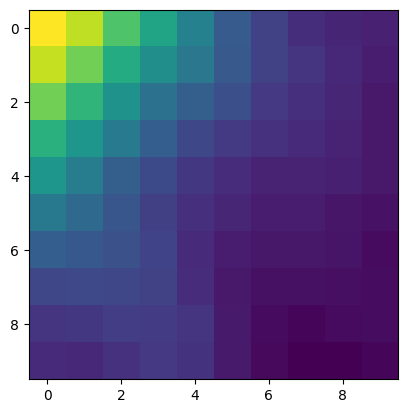

In [74]:
c, offset = crop_image(embryo[0][0], crop_origin=None, crop_width=10, crop_height=10)
print (c.shape, offset)
plt.imshow(c)